In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import itertools
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import multiprocessing
from CustomFunctions import PCvisualization, DetailedBalance

def cllct_rslts(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.extend(result)
def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)


#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [10]:
#get directories and open separated datasets

treatments = ['Random']
time_interval = 10 #sec/frame
whichpcs = ['PC1','PC7']

datadir = 'E:/Aaron/Combined_37C_Confocal_PCA_nospeedoutliers_final/'
savedir = datadir + 'random/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

TotalFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

nbins = np.max(TotalFrame[[x for x in TotalFrame.columns.to_list() if 'bin' in x]].to_numpy())

# make sure all categories are ordered
# TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=['Random','Pre-Galvanotaxis','Galvanotaxis','DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
# TotalFrame['Experiment'] = pd.Categorical(TotalFrame.Experiment.to_list(), categories=['Galvanotaxis','Drug'], ordered=True)

#restrict dataframe to only random experiments
TotalFrame = TotalFrame[TotalFrame.Treatment=='Random']

In [8]:
print(f'{len(TotalFrame)} images of {len(TotalFrame.CellID.unique())} cells')

10567 images of 227 cells


In [12]:
########### get raw transitions and pairs ###########
if (os.path.exists(savedir+f'{whichpcs[0]}-{whichpcs[1]}_transitions_separated.csv')) & (os.path.exists(savedir+f'{whichpcs[0]}-{whichpcs[1]}_transition_pairs_separated.csv')):
    rawtrans = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_transitions_separated.csv', index_col = 0)
    rawpairs = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_transition_pairs_separated.csv', index_col = 0)
    print('Opened transition files')
else:
    if __name__ ==  '__main__':
        migresults = []
        for m, Mig in TotalFrame.groupby('Treatment'):
            results = []
            pool = multiprocessing.Pool(processes=60)
            for i, cells in Mig.groupby('CellID'):
                cells = cells.sort_values('frame').reset_index(drop = True)
                runs = list()
                #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
                for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                    currentrun = list(map(itemgetter(1), g))
                    list.append(runs, currentrun)

                for r in runs:
                    r = np.array(r, dtype=int)
                    #skip runs less than 3 frames long
                    if len(r)<2:
                        pass
                    else:
                        cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]

                        pool.apply_async(DetailedBalance.pair_transitions, args = (
                            time_interval,
                            cell.CellID.iloc[0],
                            cell.frame.to_list(),
                            cell[[f'{whichpcs[0]}bins',f'{whichpcs[1]}bins']].to_numpy(),
                            ),
                            callback = collect_results)
            pool.close()
            pool.join()


            rawtrans = pd.DataFrame(sum([r[0] for r in results],[]))
            rawtrans = rawtrans.sort_values(by = ['CellID','frame']).reset_index(drop=True)
            rawpairs = pd.DataFrame(sum([r[1] for r in results],[]))
            rawtrans['Treatment'] = [m]*len(rawtrans)
            rawpairs['Treatment'] = [m]*len(rawpairs)
            migresults.append([rawtrans,rawpairs])
        
    rawtrans = pd.concat([mi[0] for mi in migresults])
    rawpairs = pd.concat([mi[1] for mi in migresults])
    rawtrans.to_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_transitions_separated.csv')
    rawpairs.to_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_transition_pairs_separated.csv')
    del migresults
    print('Aggregated transitions')


########### interpolate all transitions so that only individual transitions are made ###########
if (os.path.exists(savedir+f'interpolated_{whichpcs[0]}-{whichpcs[1]}_transitions_separated.csv')) & (os.path.exists(savedir+f'interpolated_{whichpcs[0]}-{whichpcs[1]}_transition_pairs_separated.csv')):
    transdf_sep = pd.read_csv(savedir+f'interpolated_{whichpcs[0]}-{whichpcs[1]}_transitions_separated.csv', index_col=0)
    transpairsdf_sep = pd.read_csv(savedir+f'interpolated_{whichpcs[0]}-{whichpcs[1]}_transition_pairs_separated.csv', index_col=0)
    print('Opened transition files')
    
    #ensure that DMSO is the first in order
    transdf_sep['Treatment'] = pd.Categorical(transdf_sep.Treatment, categories=treatments, ordered=True)
    transdf_sep = transdf_sep.sort_values(by='Treatment')
    transpairsdf_sep['Treatment'] = pd.Categorical(transpairsdf_sep.Treatment, categories=treatments, ordered=True)
    transpairsdf_sep = transpairsdf_sep.sort_values(by='Treatment')
else:
    if __name__ ==  '__main__':
        migresults = []
        for m, Mig in TotalFrame.groupby('Treatment'):
            results = []
            pool = multiprocessing.Pool(processes=60)
            for i, cells in Mig.groupby('CellID'):
                cells = cells.sort_values('frame').reset_index(drop = True)
                runs = list()
                #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
                for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                    currentrun = list(map(itemgetter(1), g))
                    list.append(runs, currentrun)

                for r in runs:
                    r = np.array(r, dtype=int)
                    #skip runs less than 3 frames long
                    if len(r)<2:
                        pass
                    else:
                        cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]

                        pool.apply_async(DetailedBalance.interpolate_2dtrajectory, args = (
                            time_interval,
                            cell.CellID.iloc[0],
                            cell.frame.to_list(),
                            cell[[f'{whichpcs[0]}bins',f'{whichpcs[1]}bins']].to_numpy(),
                            ),
                            callback = collect_results)
            pool.close()
            pool.join()


            transdf_sep = pd.DataFrame(sum([r[0] for r in results],[]))
            transdf_sep = transdf_sep.sort_values(by = ['CellID','frame']).reset_index(drop=True)
            transpairsdf_sep = pd.DataFrame(sum([r[1] for r in results],[]))
            transdf_sep['Treatment'] = [m]*len(transdf_sep)
            transpairsdf_sep['Treatment'] = [m]*len(transpairsdf_sep)
            migresults.append([transdf_sep,transpairsdf_sep])

    transdf_sep = pd.concat([mi[0] for mi in migresults])
    transpairsdf_sep = pd.concat([mi[1] for mi in migresults])
    transdf_sep.to_csv(savedir+f'interpolated_{whichpcs[0]}-{whichpcs[1]}_transitions_separated.csv')
    transpairsdf_sep.to_csv(savedir+f'interpolated_{whichpcs[0]}-{whichpcs[1]}_transition_pairs_separated.csv')
    del migresults
    print('Finished interpolating trajectories')
    
    
############## get the counts of cells leaving 
if os.path.exists(savedir+f'{whichpcs[0]}-{whichpcs[1]}_binned_transition_rates_separated.csv'):
    trans_rate_df_sep = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_binned_transition_rates_separated.csv', index_col=0)
    print('Opened transition rate files')
    
    #ensure that DMSO is the first in order
    trans_rate_df_sep['Treatment'] = pd.Categorical(trans_rate_df_sep.Treatment, categories=treatments, ordered=True)
    trans_rate_df_sep = trans_rate_df_sep.sort_values(by='Treatment')
else:
    trresults = []
    if __name__ ==  '__main__':
        for m, mig in transdf_sep.groupby('Treatment'):
            ttot = mig.time_elapsed.sum()
            print(ttot)
            pool = multiprocessing.Pool(processes=60)
            results = []
            for x in range(nbins):
                for y in range(nbins):
                    fromm = mig[(mig['from_x'] == x+1) & (mig['from_y'] == y+1)].reset_index(drop=True).to_dict()
                    to = mig[(mig['to_x'] == x+1) & (mig['to_y'] == y+1)].reset_index(drop=True).to_dict()
                    pool.apply_async(DetailedBalance.get_transition_counts, args = (
                        x+1,
                        y+1,
                        fromm,
                        to,
                        ttot,
                        ),
                        callback = collect_results)
            pool.close()
            pool.join()

            trans_rate_df_sep = pd.DataFrame(results)
            trans_rate_df_sep['Treatment'] = [m]*len(trans_rate_df_sep)
            trans_rate_df_sep = trans_rate_df_sep.sort_values(by = ['x','y']).reset_index(drop=True)
            trresults.append(trans_rate_df_sep)

    trans_rate_df_sep = pd.concat(trresults)
    trans_rate_df_sep.to_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_binned_transition_rates_separated.csv')
    del trresults

    print('Finished finding transition rates')



############## BOOTSTRAP MANY TRAJECTORIES ##########
#if a bootstrapped data file already exists, load it, otherwise make one
if os.path.exists(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_transition_rates.csv'):
    #open bootstrapped transitions
    bstrans = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_transitions.csv', index_col=0)
    bstrans['Treatment'] = pd.Categorical(bstrans.Treatment, categories=treatments, ordered=True)
    bstrans = bstrans.sort_values(by='Treatment')
    #open bootstrapped CGPS rates
    bsframe_sep_full = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_transition_rates.csv', index_col=0)
    #ensure that DMSO is the first in order
    bsframe_sep_full['Treatment'] = pd.Categorical(bsframe_sep_full.Treatment, categories=treatments, ordered=True)
    bsframe_sep_full = bsframe_sep_full.sort_values(by='Treatment')
    print('Opened bootstrap file')
else:
    
    #number of times to bootstrap
    bsiter = 3000
    
    bstrans = []
    bsint = []
    bspairs = []
    bsframe_sep_full = []
    
    for m, mig in rawpairs.groupby('Treatment'):
        #set the total bootstrap time to the full time observed for this sample
        ttot = 1800 #TotalFrame.frame.max()*time_interval #mig.time_elapsed.sum()#
            
        start = 0
        stop = 300
        allresults = []
        while start<bsiter:
            print(f'Starting {m} trajectory {start}-{stop}')
            if __name__ ==  '__main__':
                pool = multiprocessing.Pool(processes=60)
                results = []
                for x in range(start,stop+1):
                    pool.apply_async(DetailedBalance.bootstrap_trajectories, args = (
                        mig,
                        ttot,
                        nbins,
                        ),
                        callback = collect_results)
                pool.close()
                pool.join()

                allresults.extend(results)

            start = stop + 1
            stop = stop + 300
            if stop>bsiter:
                stop = bsiter

                
        for i, a in enumerate(allresults):
             a['iter'] = i
        migboot = pd.concat(allresults).reset_index(drop=True)
        migboot['Treatment'] = [m]*len(migboot)
        bstrans.append(migboot)

        ###### now interpolate the bootstrapped trajectories ######   
        if __name__ ==  '__main__':
            pool = multiprocessing.Pool(processes=60)
            results = []
            for i, d in migboot.groupby('iter'):
                cell = d.sort_values('cumulative_time').reset_index(drop = True)
                traj = np.vstack((cell[['from_x','from_y']].to_numpy(),cell[['to_x','to_y']].iloc[-1].to_numpy()))
                pool.apply_async(DetailedBalance.interpolate_2dtrajectory, args = (
                    time_interval,
                    cell.CellID.iloc[0],
                    list(range(len(cell))),
                    traj,
                    ),
                    callback = collect_results)
            pool.close()
            pool.join()


        bsinttrans = pd.DataFrame(sum([r[0] for r in results],[]))
        bsinttrans['iter'] = list(itertools.chain.from_iterable([[k]*len(res[0]) for k,res in enumerate(results)]))
        bsinttrans = bsinttrans.sort_values(by = ['CellID','frame']).reset_index(drop=True)
        bsinttrans['Treatment'] = [m]*len(bsinttrans)
        bsint.append(bsinttrans)
        bsinttranspairs = pd.DataFrame(sum([r[1] for r in results],[]))
        bsinttranspairs['Treatment'] = [m]*len(bsinttranspairs)
        bspairs.append(bsinttranspairs)

        
        ### now get transition rates
        start = 0
        stop = 300
        allresults = []
        while start<bsiter:
            print(f'Finished {m} rates {start}, starting {start}-{stop}')
            if __name__ ==  '__main__':
                pool = multiprocessing.Pool(processes=60)
                results = []
                for i in range(start,stop+1):
                    tempmig = migboot[migboot.iter == i]
                    ct = tempmig.time_elapsed.sum()
                    pool.apply_async(DetailedBalance.transition_count_wrapper, args = (
                        tempmig,
                        nbins,
                        ct,
                        ),
                        callback = collect_results)
                pool.close()
                pool.join()

                allresults.extend(results)

            start = stop + 1
            stop = stop + 300
            if stop>bsiter:
                stop = bsiter
                
        migrate = pd.concat(allresults).reset_index(drop=True)
        migrate['Treatment'] = [m]*len(migrate)
        iters = [[x]*(nbins**2) for x in range(int(len(migrate)/(nbins**2)))]
        migrate['bs_iteration'] = list(itertools.chain.from_iterable(iters))
        bsframe_sep_full.append(migrate)
        

    ####### pull everything together and save
    bstrans = pd.concat(bstrans)
    bstrans.to_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_transitions.csv')
    bsint = pd.concat(bsint)
    bsint.to_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_interpolated_transitions.csv')
    bspairs = pd.concat(bspairs)
    bspairs.to_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_interpolated_transition_pairs.csv')
    bsframe_sep_full = pd.concat(bsframe_sep_full)
    bsframe_sep_full.to_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_transition_rates.csv')
    
    del migboot
    del results
    del allresults
    print('Finished bootstrapping')

    

############# open average bootstrapped currents ###################
if (os.path.exists(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_transitions_average_currents.csv')):
    
    bsfield_sep = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_transitions_average_currents.csv', index_col=0)

    #ensure that DMSO is the first in order
    bsfield_sep['Treatment'] = pd.Categorical(bsfield_sep.Treatment, categories=treatments, ordered=True)
    bsfield_sep = bsfield_sep.sort_values(by='Treatment')
    print('Opened boostrapped average currents')
    
else:
    #### get current field for this bootstrap realization ######
    ####### this is for looking at data spread for the current field ############
    bsfield = []
    for m, mig in bsframe_sep_full.groupby('Treatment'):
        for x in range(nbins):
            for y in range(nbins):
                current = mig[(mig['x'] == x+1) & (mig['y'] == y+1)]
                js = np.array([[[(row.x_plus_rate - row.x_minus_rate)/2, 0],[0,(row.y_plus_rate - row.y_minus_rate)/2]] for i, row in current.iterrows()])
                avgjs = np.mean(js, axis = 0)
                evals, evecs = np.linalg.eigh(avgjs)
                bsfield.append({'x':x+1,
                                'y':y+1,
                                'eval1':evals[1],
                                'eval2':evals[0],
                               'evec1x':evecs[0,1],
                               'evec1y':evecs[1,1],
                               'evec2x':evecs[0,0],
                               'evec2y':evecs[1,0],
                              'Treatment':m})

    bsfield_sep = pd.DataFrame(bsfield)
    bsfield_sep.to_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_transitions_average_currents.csv')

Aggregated transitions
Finished interpolating trajectories
89560.71677767362
Finished finding transition rates
Starting Random trajectory 0-300
Starting Random trajectory 301-600
Starting Random trajectory 601-900
Starting Random trajectory 901-1200
Starting Random trajectory 1201-1500
Starting Random trajectory 1501-1800
Starting Random trajectory 1801-2100
Starting Random trajectory 2101-2400
Starting Random trajectory 2401-2700
Starting Random trajectory 2701-3000
Finished Random rates 0, starting 0-300
Finished Random rates 301, starting 301-600
Finished Random rates 601, starting 601-900
Finished Random rates 901, starting 901-1200
Finished Random rates 1201, starting 1201-1500
Finished Random rates 1501, starting 1501-1800
Finished Random rates 1801, starting 1801-2100
Finished Random rates 2101, starting 2101-2400
Finished Random rates 2401, starting 2401-2700
Finished Random rates 2701, starting 2701-3000
Finished bootstrapping


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


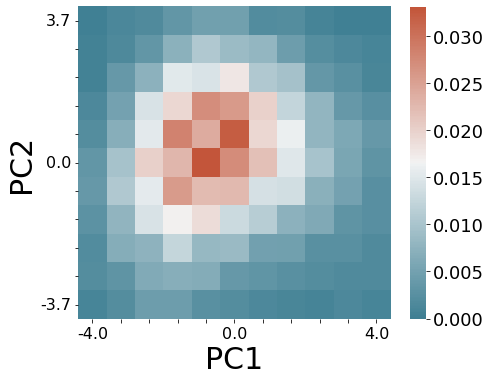

In [4]:
################ heatmap of probability density #############
#calculate the total time observed during the experiment
ttot = transdf.time_elapsed.sum()

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.sum()/ttot

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC1.to_list()],
    fontsize = 16
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC1_PC2 probability density heatmap.png', bbox_inches='tight')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


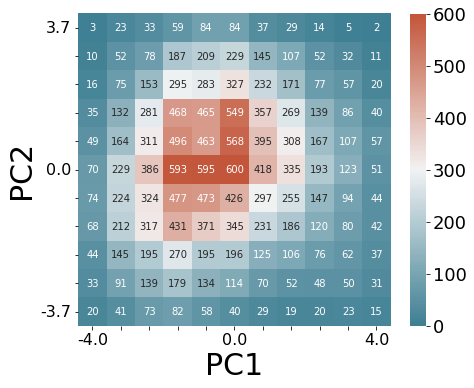

In [5]:
################ PLOT THE COUNTS OF THE BINS #############
#calculate the total time observed during the experiment
ttot = transdf.time_elapsed.sum()

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = len(current)

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    fmt = '.0f',
    ax = ax,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC1.to_list()],
    fontsize = 16
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC1_PC2 transition count heatmap.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


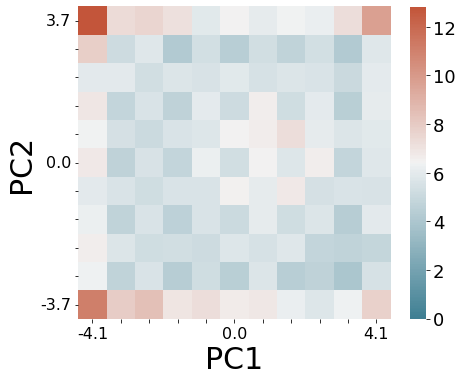

In [14]:
################ heatmap of AVERAGE DWELL TIME #############

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.mean()

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC1.to_list()],
    fontsize = 16
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC1_PC2 avg dwell time heatmap.png', bbox_inches='tight')

In [ ]:
########## PC1/PC2 transition with error ellipses oriented to PCs ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0005

# combine fake error data with real transition data
elldf = bsframe.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})


meshdir = datadir + 'PC_Meshes/'

proj=[0,1]
PCkey = [1,2]
binkey = [1,5]      

fig = plt.figure(figsize=(10,10))

graphaxes, axes = PCvisualization.get_contours_for_axes(meshdir,
                proj,
                PCkey,
                binkey,
                )

    

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    graphaxes[0].axhline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # horizontal lines
    graphaxes[0].axvline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # vertical lines

#add contou line if desired
uple = [3,8]
lori = [8,4]
contourcoords = contour_coords(uple,lori)

#actually plot the contour
graphaxes[0].plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='black',alpha=0.3, zorder = 1 * 5)

    
    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        
        ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                width=np.sqrt(current.eval1)*(1/scale)*2,
                  height=np.sqrt(current.eval2)*(1/scale)*2,
                angle=np.arctan2(current.evec1y,current.evec1x))
        graphaxes[0].add_artist(ell)
        ell.set_alpha(0.2)
        ell.set_zorder(2 * 5)
#         print(np.sqrt(current.eval1), np.sqrt(current.eval2))

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        graphaxes[0].quiver(x,
                   y, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = cmm(norm(anglecolor)),
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
graphaxes[0].set_xlabel('PC1', fontsize = 34)
graphaxes[0].set_ylabel('PC2', fontsize = 34)
graphaxes[0].set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 18)
graphaxes[0].set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 18)
graphaxes[0].set_xlim(0,nbins+1)
graphaxes[0].set_ylim(0,nbins+1)

#legend background
lxp = 0.125
lyp = 10.25
rect = Rectangle((lxp, lyp), 1.625, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
graphaxes[0].add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
graphaxes[0].text(lxp+0.3,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
graphaxes[0].text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()



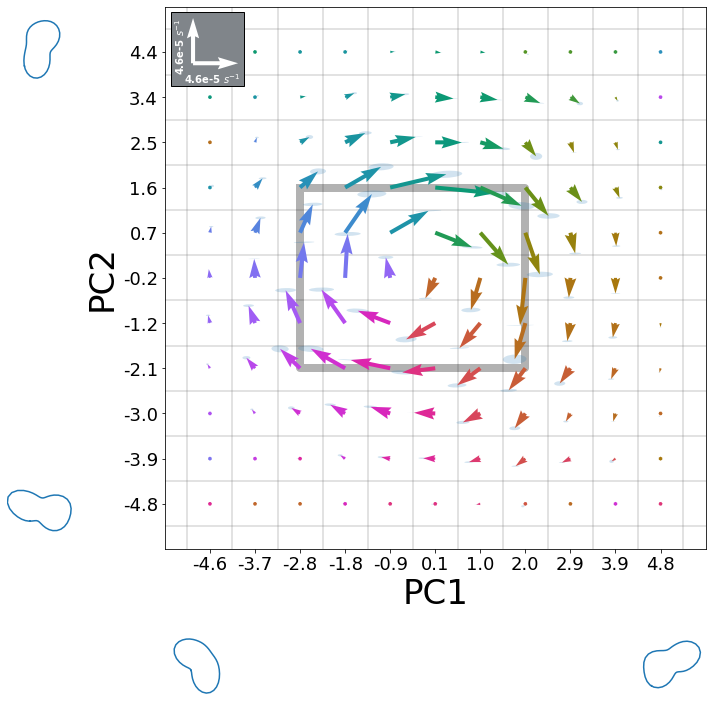

In [29]:
########## PC1/PC2 transition with error ellipses oriented to PCs ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0005

# combine fake error data with real transition data
elldf = bsframe.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})


meshdir = datadir + 'PC_Meshes/'

proj=[0,1]
PCkey = [1,2]
binkey = [1,5]      

fig = plt.figure(figsize=(10,10))

graphaxes, axes = PCvisualization.get_contours_for_axes(meshdir,
                proj,
                PCkey,
                binkey,
                )

    

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    graphaxes[0].axhline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # horizontal lines
    graphaxes[0].axvline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # vertical lines

#add contou line if desired
uple = [3,8]
lori = [8,4]
contourcoords = contour_coords(uple,lori)

#actually plot the contour
graphaxes[0].plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='black',alpha=0.3, zorder = 1 * 5)

    
    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        
        ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                width=np.sqrt(current.eval1)*(1/scale)*2,
                  height=np.sqrt(current.eval2)*(1/scale)*2,
                angle=np.arctan2(current.evec1y,current.evec1x))
        graphaxes[0].add_artist(ell)
        ell.set_alpha(0.2)
        ell.set_zorder(2 * 5)
#         print(np.sqrt(current.eval1), np.sqrt(current.eval2))

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        graphaxes[0].quiver(x,
                   y, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = cmm(norm(anglecolor)),
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
graphaxes[0].set_xlabel('PC1', fontsize = 34)
graphaxes[0].set_ylabel('PC2', fontsize = 34)
graphaxes[0].set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 18)
graphaxes[0].set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 18)
graphaxes[0].set_xlim(0,nbins+1)
graphaxes[0].set_ylim(0,nbins+1)

#legend background
lxp = 0.125
lyp = 10.25
rect = Rectangle((lxp, lyp), 1.625, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
graphaxes[0].add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
graphaxes[0].text(lxp+0.3,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
graphaxes[0].text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()



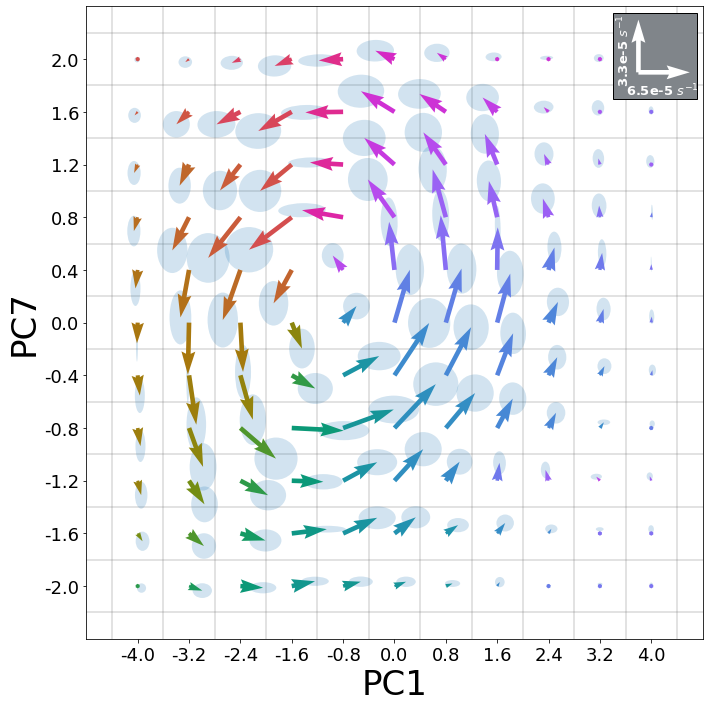

In [7]:
########## PC1/PC7 transition with error ellipses oriented to PCs WITHOUT PC MESH SLICES ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0008

# combine fake error data with real transition data
elldf = bsfield_sep.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})



fig, ax = plt.subplots(figsize=(10,10))
    

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # vertical lines

    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

        ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                width=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1x.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                  height=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1y.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                angle=np.arctan2(current.evec1y,current.evec1x))
        ax.add_artist(ell)
        ell.set_alpha(0.2)

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        ax.quiver(x,
                   y, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = cmm(norm(anglecolor)),
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
ax.set_xlabel('PC1', fontsize = 34)
ax.set_ylabel('PC7', fontsize = 34)
ax.set_xticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC1.to_list()], fontsize = 18)
ax.set_yticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC7.to_list()], fontsize = 18)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)

#legend background
lxp = 10.25
lyp = 10.25
rect = Rectangle((lxp, lyp), 1.645, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
ax.add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(centers.PC1.to_list()).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
ax.text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(centers.PC7.to_list()).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
ax.text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()

plt.savefig(savedir + 'PC1_PC7 Vector map absolute angle colored.png', bbox_inches='tight')

In [9]:
bsfield_sep

,x,y,eval1,eval2,evec1x,evec1y,evec2x,evec2y
0,1,1,1.385315e-06,-5.795914e-07,1.0,0.0,0.0,1.0
1,1,2,2.646664e-06,-3.074363e-06,1.0,0.0,0.0,1.0
2,1,3,5.815334e-06,-6.375770e-06,1.0,0.0,0.0,1.0
3,1,4,8.996057e-06,-1.418619e-05,1.0,0.0,0.0,1.0
4,1,5,4.493324e-06,-1.950998e-05,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
116,11,7,1.629122e-06,-1.970438e-06,0.0,1.0,1.0,0.0
117,11,8,2.919453e-06,-4.078152e-06,0.0,1.0,1.0,0.0
118,11,9,9.245421e-07,-5.774745e-06,0.0,1.0,1.0,0.0
119,11,10,-8.270448e-07,-9.052247e-07,1.0,0.0,0.0,1.0


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


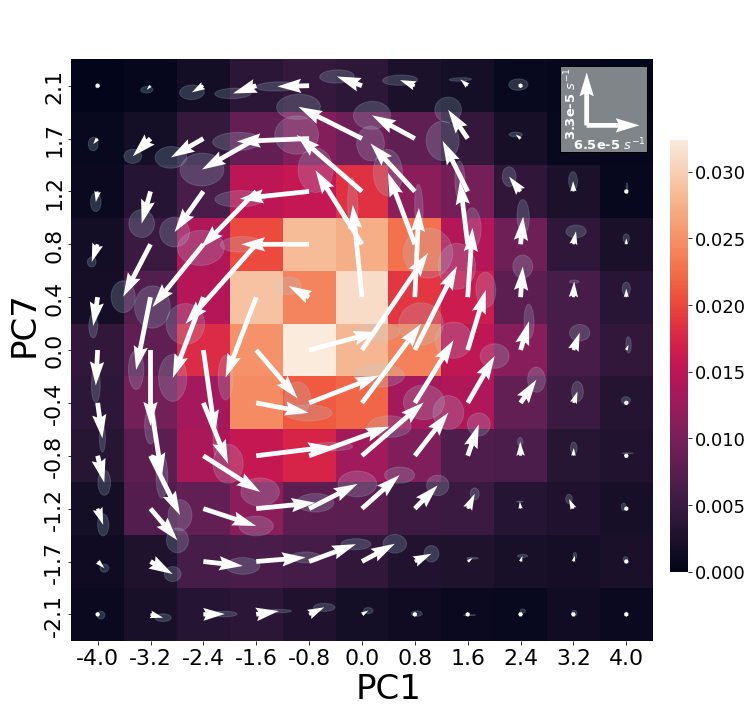

In [16]:
########## PC1/PC7 transition with error ellipses oriented to PCs WITHOUT PC MESH SLICES ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0008

# combine fake error data with real transition data
elldf = bsfield_sep.merge(trans_rate_df_sep,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})



fig, ax = plt.subplots(figsize=(10,10))

cbar_ax = fig.add_axes([0.93, .2, .025, .6])


ttot = transdf_sep.time_elapsed.sum()
#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf_sep[(transdf_sep['from_x'] == x+1) & (transdf_sep['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.sum()/ttot
#plot heatmap with seaborn
sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap='rocket',
    square=True,
    xticklabels = True,
    yticklabels = True,
    ax = ax,
#     cbar=i==0,
    cbar_ax = cbar_ax,
#         cbar_kws=cbar_kws
)


    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

        ell = Ellipse(xy=(x-0.5+(xcurrent.values*(1/scale)),y-0.5+(ycurrent.values*(1/scale))),
                width=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1x.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                  height=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1y.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                angle=np.arctan2(current.evec1y,current.evec1x),
                     color = 'lightblue')
        ax.add_artist(ell)
        ell.set_alpha(0.2)

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        ax.quiver(x-0.5,
                   y-0.5, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = 'white',
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
ax.set_xlabel('PC1', fontsize = 34)
ax.set_ylabel('PC7', fontsize = 34)
ax.set_xticks(np.arange(0.5,nbins+0.5))
ax.set_xticklabels([round(x,1) for x in centers.PC1.to_list()], fontsize = 22)
ax.set_yticks(np.arange(0.5,nbins+0.5))
ax.set_yticklabels([round(x,1) for x in centers.PC7.to_list()], fontsize = 22)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)

#legend background
lxp = 9.25
lyp = 9.25
rect = Rectangle((lxp, lyp), 1.645, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
ax.add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(centers.PC1.to_list()).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
ax.text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(centers.PC7.to_list()).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
ax.text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()

plt.savefig(savedir + 'PC1_PC7 Vector map and pdf.png', bbox_inches='tight')

In [29]:
############## bootstrapped AERs #################
from CustomFunctions.DetailedBalance import get_area_enclosing_rate

whichpcs = ['PC1','PC7']
xyscaling = [centers[whichpcs[0]].diff().mean(),centers[whichpcs[1]].diff().mean()]
center = [5,6]

if os.path.exists(savedir+f'PC1-PC7_Area_Enclosing_Rates.csv'):
    allaers = pd.read_csv(savedir+f'PC1-PC7_Area_Enclosing_Rates.csv', index_col=0)
    allaers['Treatment'] = pd.Categorical(allaers.Treatment, categories=['DMSO','CK666'], ordered=True)
    allaers = allaers.sort_values(by='Treatment')
    print('Opened aers')
else:
    bstrans = pd.read_csv(savedir+f'PC1-PC7_bootstrapped_transitions.csv', index_col=0)

    start = 0
    stop = 200
    allresults = []

    while start<bstrans.iter.max():
        print(f'Finished {start}, starting {start}-{stop}')
        if __name__ ==  '__main__':
            pool = multiprocessing.Pool(processes=60)
            results = []
            for x in range(start,stop+1):
                b = bstrans[bstrans.iter==x]
                b = b.sort_values('cumulative_time').reset_index(drop = True)
                pool.apply_async(get_area_enclosing_rate, args = (
                    b,
                    nbins,
                    xyscaling,
                    center,
                    ),
                    callback = collect_results)
            pool.close()
            pool.join()

            allresults.extend(results)

            start = stop + 1
            stop = stop + 200
            if stop>bstrans.iter.max():
                stop = bstrans.iter.max()

    migboot = pd.DataFrame()
    migboot['aer'] = [a.aer.sum() for a in allresults]
    migboot['Treatment'] = ['Random']*len(migboot)

    migboot = migboot.reset_index(drop=True)
    migboot.to_csv(savedir+'PC1-PC7_Area_Enclosing_Rates.csv')

Opened aers


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-210.62991295001663 0.0


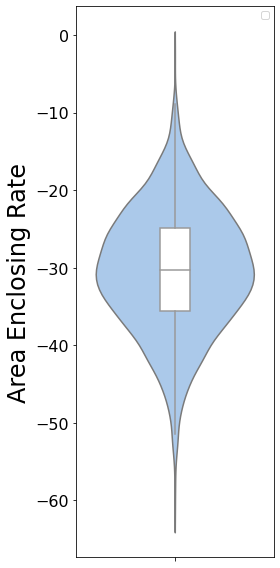

In [31]:
import scipy.stats as stats
t_statistic, p_value = stats.ttest_1samp(a=allaers.aer, popmean=0) 
print(t_statistic , p_value)
################ histograms of the contour integral distributions ###########

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=allaers, y = 'aer',
               palette = colorlist, inner = None, ax=ax)
sns.boxplot(data=allaers,y='aer', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax)

#labelste
ax.set_ylabel('Area Enclosing Rate', fontsize=24)#, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=16)
ax.set_xticklabels([''], fontsize = 14)
# ax.text(0,1,'***',fontdict= {'fontsize': 22,
#                                'horizontalalignment':'center'})


plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'alldata aer.png', bbox_inches='tight', dpi = 500)


In [20]:
######### do contour integrals ################
from CustomFunctions.DetailedBalance import contour_integral

uple = [3,8]
lori = [8,3]
if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}.csv'):
    omegas = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}.csv', index_col=0)
else:
    omegas = []
    for b in bslist:
        omegas.append(contour_integral(b, uple, lori, norm = False))
    omegas = pd.DataFrame(list(zip(omegas/pd.Series(omegas).std(),['omega']*len(omegas))), columns=['Norm_Omegas','sample'])
    omegas.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv')

In [14]:
################ histograms of the contour integral distributions ###########


colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=omegas, y = 'Norm_Omegas',
               palette = colorlist, inner = None, ax=ax)
sns.boxplot(data=omegas,y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax)

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=30, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
ax.set_xticklabels([''], fontsize = 14)



plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori}.png', bbox_inches='tight', dpi = 500)


NameError: name 'data' is not defined

In [22]:
######### do NORMALIZED contour integrals ################
from CustomFunctions.DetailedBalance import contour_integral

uple = [3,8]
lori = [8,4]
if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv'):
    omegas_norm = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv', index_col=0)
else:
    omegas = []
    for b in bslist:
        omegas.append(contour_integral(b, uple, lori, norm = True))
    omegas_norm = pd.DataFrame(list(zip(omegas/pd.Series(omegas).std(),['omega']*len(omegas))), columns=['Norm_Omegas','sample'])
    omegas_norm.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv')

(210.32165930822035, 0.0)


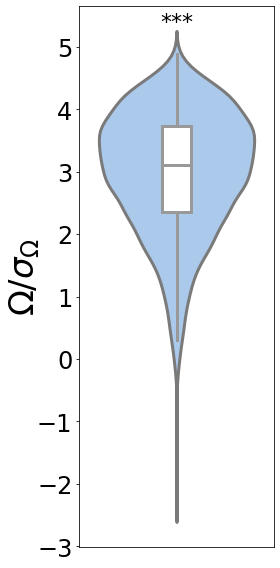

In [38]:
################ histograms of the contour integral distributions ###########
from statsmodels.stats.weightstats import ztest as ztest
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=omegas_norm, y = 'Norm_Omegas',
               palette = colorlist, linewidth = 3, inner = None, ax=ax)
sns.boxplot(data=omegas_norm,y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, linewidth = 3, boxprops={'zorder': 2}, 
            ax=ax)

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=34, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=24)
ax.set_xticklabels([''], fontsize = 14)
ax.set_xticks([])

ax.text(0,5.3,'***',fontdict= {'fontsize': 22,
                               'horizontalalignment':'center'})
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori} normalized.png', bbox_inches='tight', dpi = 500)
print(str(ztest(omegas_norm.Norm_Omegas, value=0)))

In [ ]:
################## how are the PC bins changing over time #########################
difflist = []
for i, d in TotalFrame[['CellID','Migration_Mode','frame','PC1bins','PC2bins','PC3bins','PC4bins']].sort_values(by='frame').groupby('CellID'):
    dtemp = d[['frame','PC1bins','PC2bins','PC3bins','PC4bins']].diff()
    dtemp = dtemp[dtemp.frame==1]
    dtemp['frame'] = d.frame[dtemp.index]
    dtemp['CellID'] =  [i]*len(dtemp)
    dtemp['Migration_Mode'] = d.Migration_Mode[dtemp.index]
    difflist.append(dtemp)
diffdf = pd.concat(difflist)

fig, axes = plt.subplots(4, 1, figsize=(20,40), sharey=True)
for a, ax in enumerate(axes):
    cpc = [x for x in diffdf.columns.to_list() if 'PC' in x][a]
    sns.boxplot(data=diffdf, x='frame', hue='Migration_Mode',y=cpc, ax=ax)
    ax.set_xticklabels(
        np.sort(diffdf.frame.unique()).astype(int),
        rotation=-45,
        fontsize = 12
        )
    #set axis titles
    ax.set_ylabel(cpc, fontsize = 30)
    ax.set_xlabel('Frame', fontsize = 22)
plt.tight_layout()
fig.savefig(savedir+'PC bin differentials.png', facecolor='white')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in 

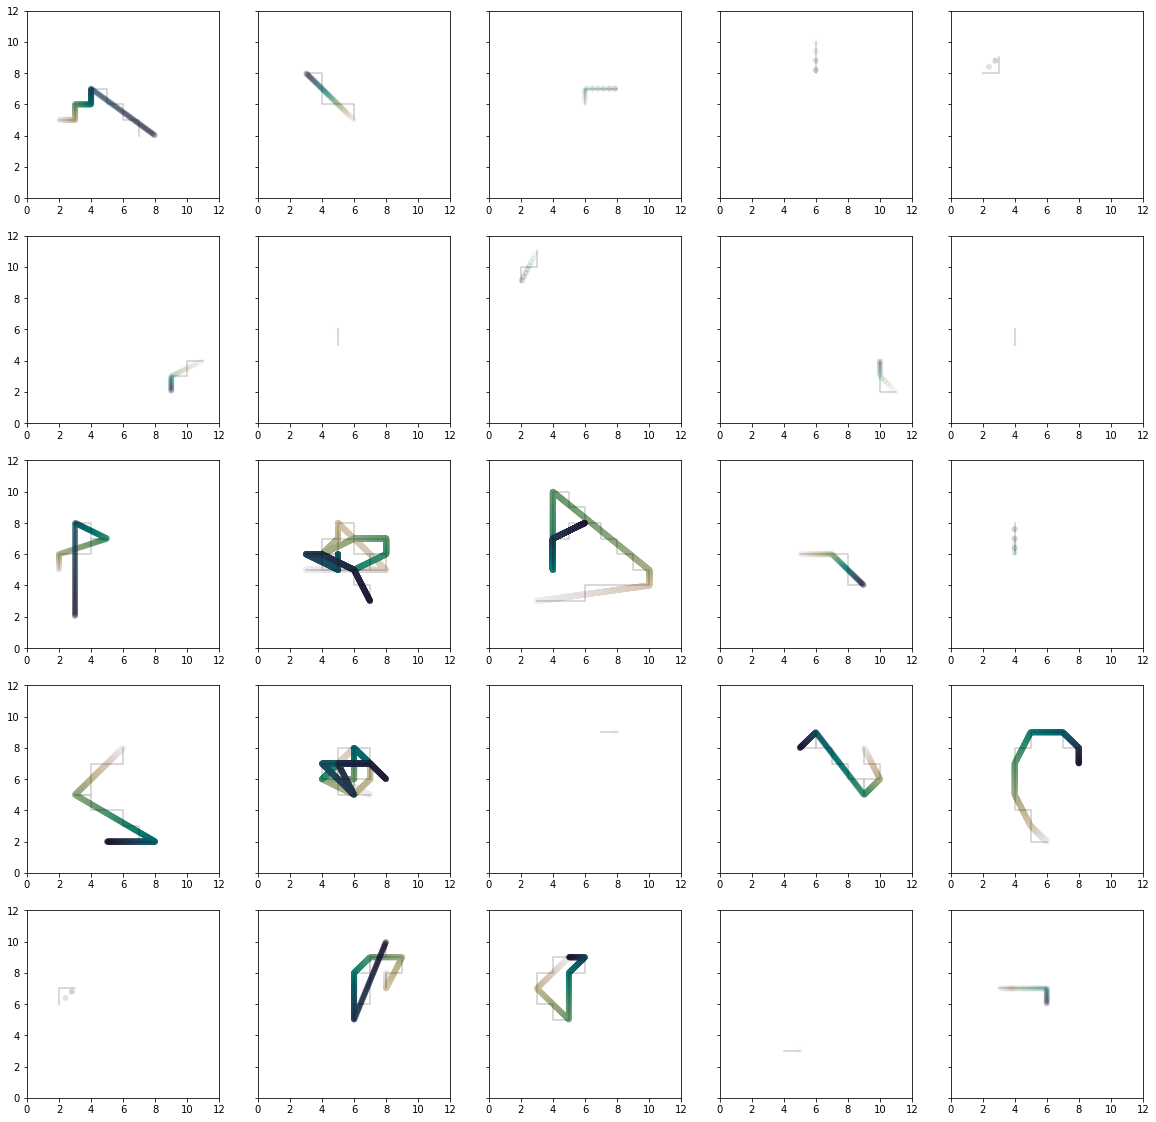

In [45]:
############# grid of plots of individual cells' INTERPOLATED transitions ###################

########### '20230509_488EGFP-CAAX_640SPY650-DNA2_cell_5' performs the exact loop #############

#the square root of plot number
pnum = 5
#randomly choose cells
sample = random.sample(list(transdf.CellID.unique()), pnum**2)

from cmocean import cm
norm = matplotlib.colors.Normalize()
cmm = cm.rain



fig, axes = plt.subplots(pnum,pnum,figsize=(20,20), sharey=True)
s = 0
#make numpy array with heatmap data
for x in range(pnum):
    for y in range(pnum):
        axes[x,y].set_xlim(0,nbins+1)
        axes[x,y].set_ylim(0,nbins+1)
        #get the next cell in the sample
        temp = transdf[transdf.CellID == sample[s]].reset_index(drop=True)
        #if temp is only 1 transition resample
        if len(temp)<2:
            temp = transdf[transdf.CellID == random.sample(list(transdf.CellID.unique()), 1)].reset_index(drop=True)
        #only get continuous frames 
        frames = temp[temp.frame.diff()>1].index.values
        if frames.size>0:
            if temp.index.values[0] != frames[0]:
                frames = np.append(temp.index.values[0], frames)
            if temp.index.values[-1] != frames[-1]:
                frames = np.append(frames, temp.index.values[-1])
            st = random.randrange(len(frames)-1)
            temp = temp.loc[frames[st]:frames[st+1]-1]
#             print(temp)
#         if s == len(sample)-1:
#             temp = alltrans.copy()
#             print(x,y)

        
        #get values of actual transitions based on the interpolated transitions
        fli = temp.frame.to_list()+[temp.frame.to_list()[-1]+1]
        acttemp = TotalFrame[(TotalFrame.CellID==temp.CellID.values[0])&(TotalFrame.frame.isin(fli))].sort_values(by='frame').reset_index(drop=True)
        #interpolate along the trajectory so I can plot dots which will represent the color gradient line
        px = acttemp.PC1bins.to_numpy()
        py = acttemp.PC2bins.to_numpy()
        pz = acttemp.frame.to_numpy()
        dist = np.nansum(scipy.spatial.distance.pdist(temp[['from_x','from_y']]))
        fx = scipy.interpolate.interp1d(np.arange(1,len(px)+1),px)
        newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
        fy = scipy.interpolate.interp1d(np.arange(1,len(py)+1),py)
        newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
        newz = np.arange(0,len(temp), len(temp)/len(newy))
        if len(newz)>len(newy):
            newz = newz[:-1]
        #normalize to the colors to the length of the trajectory
        norm.autoscale([0,newz.max()])
        #plot the actual transitions
        axes[x,y].scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.2, edgecolors='none')
        
        #plot the interpolated transitions
        ix = np.append(temp.from_x.to_numpy(), temp.to_x.to_numpy()[-1])
        iy = np.append(temp.from_y.to_numpy(), temp.to_y.to_numpy()[-1])
        axes[x,y].plot(ix, iy, color ='black', alpha=0.2)
        
        #add one to the sample count
        s = s+1

In [4]:
############### get shcoeffs for different positions around a particular 2d contour #############
from CustomFunctions.PCvisualization import interpolate_contour_shapes
import pickle as pk
from scipy import interpolate
from scipy.spatial import distance
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x and '_' not in x]].mean().to_numpy()

pca = pk.load(open('/'.join(savedir.split('/')[:-2])+"/pca.pkl",'rb'))

PC1bins = centers.PC1.to_numpy()
PC2bins = centers.PC2.to_numpy()

whichpcs = [1,2]
lmax = 10
metrics = ['speed']
vertices = np.array([[8,8],
                    [8,3],
                    [3,3],
                    [3,8]])

contour_positions, loopname, metricsarray = interpolate_contour_shapes(vertices,
                               avgpcs,
                               whichpcs,
                               pca,
                               PC1bins,
                               PC2bins,
                               savedir,
                               lmax,
                               TotalFrame,
                               metrics)



In [10]:
pd.DataFrame(metricsarray)

,arbitrarytime,PC1bin,PC2bin,speed
0,0.000,8.0,8.0,0.071839
1,0.005,8.0,7.9,0.071839
2,0.010,8.0,7.8,0.071839
3,0.015,8.0,7.7,0.071839
4,0.020,8.0,7.6,0.071839
...,...,...,...,...
195,0.975,7.5,8.0,0.071839
196,0.980,7.6,8.0,0.071839
197,0.985,7.7,8.0,0.071839
198,0.990,7.8,8.0,0.071839


In [ ]:
########## animate a contour loop graph
from matplotlib.animation import FuncAnimation 

scale = 0.0005

#make fig
fig, ax = plt.subplots(figsize = (10,10))

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

    

for x in range(nbins):
    for y in range(nbins):
        current = trans_rate_df[(trans_rate_df['x'] == x+1) & (trans_rate_df['y'] == y+1)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
#             print(anglecolor)
        ax.quiver((x+1),
                   (y+1), 
                   xcurrent, 
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = 'black',
                 alpha = 0.2)    
    
    

ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 24)
ax.set_ylabel('PC2', fontsize = 24)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# ax.set_title(mm, fontsize = 30)


# create a point in the axes
point, = ax.plot(contour_positions[0,1],contour_positions[0,2], marker="o", color = '#eb4034', markersize = 15)

# make function for updating point position
def animate(i, contour_positions):
    point.set_data([contour_positions[i,1]], [contour_positions[i,2]])
    return point,

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(contour_positions))), fargs = (contour_positions,))
# plt.show()

ani.save(savedir + 'contours/' + loopname + f'/{loopname}_plotanimation_PC1-PC2.mp4', fps=30, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


In [4]:
############## get the actual bin position reconstructions for still images ##########

from CustomFunctions.PCvisualization import mesh_from_bins
import pickle as pk

avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x and 'dist' not in x]].mean().to_numpy()

pca = pk.load(open(datadir+"pca.pkl",'rb'))

whichpcs = [1,2]
lmax = 10



specific_positions = np.array([
[3,8],
[5.5,8],
[8,8],
[8,6],
[8,4],
[5.5,4],
[3,4],
[3,6]])



for x in specific_positions:
    specificdir = savedir + str(x) + '.vtp'
    mesh_from_bins(x,
                   whichpcs,
                   avgpcs,
                   PC1bins,
                   PC2bins,
                   pca,
                   specificdir,
                   lmax,
                   )
